In [1]:
#DATA MANIPULATION
import pandas as pd
import numpy as np

#EMBEDDING AND PREPROCESSING
from gensim.models import KeyedVectors
import re
import nltk
import gensim
import multiprocessing
import spacy
from sklearn.preprocessing import LabelBinarizer

#TIME CONTROLS
import time

#PLOT
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

#TENSORFLOW AND KERAS
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional, GlobalAveragePooling1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer

import random

Using TensorFlow backend.


In [2]:
def load_embedding(filename, encoding='utf-8'):
    # load embedding into memory, skip first line
    file = open(filename,'r',encoding=encoding)
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        try:
            embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
        except:
            pass
    return embedding

In [3]:
def get_weight_matrix(embedding, vocab, seq_len):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, seq_len))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [4]:
def cleaning(doc):
    txt = [token.text for token in doc]
    if len(txt) > 2:        
        return re.sub(' +', ' ', ' '.join(txt)).strip()

In [5]:
def preprocess_string(string, word_vectors):
    unk_string = '<unk>'
    counter = 0
    string = re.sub('[().\\/\-_\+":“0-9]', ' ', str(string)).lower()
    for word in string.split():
        try:
            word_vectors[word]
            string_to_attatch = word
        except:
            string_to_attatch = unk_string
        
        if counter:
            string = string +' '+ string_to_attatch
        else:
            string = string_to_attatch
            counter = 1
    
    return string

In [6]:
def pad_sequence(string, tokenizer):
    encoded_string = tokenizer.texts_to_sequences(string)
    padded_enconded = pad_sequences(encoded_string, maxlen=max_length, padding='post')
    return padded_enconded

In [7]:
def preprocess_to_predict(string, word_vectors, tokenizer):
    string = preprocess_string(string, word_vectors)    
    padded_sequence = pad_sequence(string, tokenizer)
    
    return padded_sequence

In [8]:
categories = []
with open('CATEGORIES.txt','r',encoding='utf-8') as f:
    for line in f.read().splitlines():
        categories.append(line)
categories

['Luminarias',
 'Transformadores',
 'Caixas',
 'CDs e DVDs',
 'Celulares',
 'Televisores',
 'Carregadores',
 'Tablets',
 'Baterias',
 'Notebooks',
 'Imóveis',
 'Portas',
 'Cadeiras',
 'Servidores',
 'Armários',
 'Monitores',
 'Ar condicionado',
 'Mesas',
 'Gaveteiros',
 'Vasos',
 'Sofás',
 'Microondas',
 'Computadores',
 'Projetores',
 'Gravadores',
 'Impressoras',
 'Camas',
 'Fornos',
 'Jogos',
 'Pedras',
 'Relógios',
 'Fogão',
 'Geladeiras',
 'Automóveis',
 'Instrumentos Musicais']

In [9]:
cores = multiprocessing.cpu_count()

In [10]:
df = pd.read_csv('description_list_categorized.csv',sep=';',encoding='latin1').dropna()
df.head()

,Description,Category
0,20 Gaveteiros,19
1,Carregador de bateria BLACK &amp; DECKER,7
2,Aprox. 11 Peças - Caixas para exibição de film...,3
3,Refrigerador 6 portas - Gelopar,12
4,"Aprox. 16 Peças: Conjuntos Alpes, Conjunto Ori...",3


In [11]:
raw_embedding = load_embedding('glove_s50.txt')

In [12]:
txt = [preprocess_string(doc, raw_embedding) for doc in df['Description']]

In [13]:
df_clean = pd.DataFrame({'clean': txt})
#df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(10082, 1)

In [14]:
df_clean.tail()

,clean
10077,aprox manoplas rotativas mpw weg para porta pa...
10078,apenas vaso
10079,peças caixas de som para <unk> conversor pata ...
10080,mesa de vidro para computador
10081,mesa redonda e vidro


In [15]:
x_input = df_clean['clean'].values.tolist()
labels = df['Category'].values.tolist()

In [16]:
temp_df = pd.DataFrame(list(zip(x_input,labels)), columns=['clean','Category']).dropna()
len(temp_df)

10082

In [17]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(temp_df['Category'])
transformed = jobs_encoder.transform(temp_df['Category'])
ohe_df = pd.DataFrame(transformed)
temp_df = pd.concat([temp_df, ohe_df], axis=1).drop(['Category'], axis=1)
temp_df = temp_df.dropna()

In [18]:
labels_df = temp_df.drop(['clean'], axis=1)
y = labels_df.values
y.shape

(10082, 35)

In [19]:
x_input = temp_df['clean'].values.tolist()
len(x_input)

10082

In [20]:
t = Tokenizer()
t.fit_on_texts(x_input)
vocab_size = len(t.word_index) + 1

In [21]:
embedding_vectors = get_weight_matrix(raw_embedding, t.word_index, seq_len=50)

In [22]:
encoded_docs = t.texts_to_sequences(x_input)

In [23]:
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [24]:
padded_docs.shape

(10082, 200)

In [25]:
y.shape

(10082, 35)

In [26]:
e = Embedding(vocab_size, 50, weights=[embedding_vectors],mask_zero=False, input_length=max_length, trainable=False)

In [27]:
#ARCHTECTURE #1
try:
    del model
except:
    pass
model = Sequential()
model.add(e)
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(35, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

"\n#ARCHTECTURE #1\n\ntry:\n    del model\nexcept:\n    pass\nmodel = Sequential()\nmodel.add(e)\nmodel.add(MaxPooling1D())\nmodel.add(Flatten())\nmodel.add(Dense(16, activation='relu'))\nmodel.add(Dense(35, activation='sigmoid'))\n\nmodel.compile(loss='categorical_crossentropy',\n              optimizer=Adam(lr=0.001),\n              metrics=['accuracy'])\n"

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           293600    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 35)                1155      
Total params: 390,531
Trainable params: 96,931
Non-trainable params: 293,600
_________________________________________________________________


In [30]:
hist = model.fit([padded_docs], 
                 y, 
                 validation_split=0.2,
                 epochs=200,
                 batch_size=64, 
                 shuffle=True,
                 verbose=2
                )

Train on 8065 samples, validate on 2017 samples
Epoch 1/200
8065/8065 - 25s - loss: 3.2162 - accuracy: 0.0972 - val_loss: 3.0977 - val_accuracy: 0.1185
Epoch 2/200
8065/8065 - 25s - loss: 3.0590 - accuracy: 0.1316 - val_loss: 3.0174 - val_accuracy: 0.1428
Epoch 3/200
8065/8065 - 25s - loss: 3.0067 - accuracy: 0.1389 - val_loss: 3.0136 - val_accuracy: 0.1403
Epoch 4/200
8065/8065 - 25s - loss: 2.9950 - accuracy: 0.1349 - val_loss: 2.9972 - val_accuracy: 0.1423
Epoch 5/200
8065/8065 - 25s - loss: 2.9743 - accuracy: 0.1371 - val_loss: 2.9685 - val_accuracy: 0.1428
Epoch 6/200
8065/8065 - 25s - loss: 2.9832 - accuracy: 0.1418 - val_loss: 2.9973 - val_accuracy: 0.1423
Epoch 7/200
8065/8065 - 26s - loss: 2.9834 - accuracy: 0.1406 - val_loss: 2.9906 - val_accuracy: 0.1438
Epoch 8/200
8065/8065 - 25s - loss: 2.9807 - accuracy: 0.1414 - val_loss: 2.9878 - val_accuracy: 0.1428
Epoch 9/200
8065/8065 - 25s - loss: 2.9720 - accuracy: 0.1407 - val_loss: 2.9879 - val_accuracy: 0.1438
Epoch 10/200
806

Epoch 79/200
8065/8065 - 26s - loss: 1.5525 - accuracy: 0.5474 - val_loss: 1.4982 - val_accuracy: 0.5855
Epoch 80/200
8065/8065 - 25s - loss: 1.3444 - accuracy: 0.6041 - val_loss: 2.6574 - val_accuracy: 0.1800
Epoch 81/200
8065/8065 - 25s - loss: 1.3876 - accuracy: 0.5902 - val_loss: 1.3500 - val_accuracy: 0.6282
Epoch 82/200
8065/8065 - 25s - loss: 1.1847 - accuracy: 0.6614 - val_loss: 2.8226 - val_accuracy: 0.1939
Epoch 83/200
8065/8065 - 25s - loss: 1.4342 - accuracy: 0.5798 - val_loss: 1.3642 - val_accuracy: 0.6153
Epoch 84/200
8065/8065 - 25s - loss: 1.1617 - accuracy: 0.6735 - val_loss: 1.2840 - val_accuracy: 0.6653
Epoch 85/200
8065/8065 - 25s - loss: 1.1192 - accuracy: 0.6924 - val_loss: 2.0444 - val_accuracy: 0.3614
Epoch 86/200
8065/8065 - 25s - loss: 1.1692 - accuracy: 0.6723 - val_loss: 2.3074 - val_accuracy: 0.2717
Epoch 87/200
8065/8065 - 25s - loss: 1.2329 - accuracy: 0.6551 - val_loss: 1.6361 - val_accuracy: 0.4561
Epoch 88/200
8065/8065 - 25s - loss: 1.0522 - accuracy:

Epoch 157/200
8065/8065 - 26s - loss: 0.9990 - accuracy: 0.7121 - val_loss: 1.4392 - val_accuracy: 0.5642
Epoch 158/200
8065/8065 - 26s - loss: 0.8055 - accuracy: 0.7799 - val_loss: 1.0004 - val_accuracy: 0.7457
Epoch 159/200
8065/8065 - 26s - loss: 0.7339 - accuracy: 0.8089 - val_loss: 2.3423 - val_accuracy: 0.3262
Epoch 160/200
8065/8065 - 26s - loss: 0.8747 - accuracy: 0.7593 - val_loss: 1.5098 - val_accuracy: 0.5409
Epoch 161/200
8065/8065 - 26s - loss: 0.8318 - accuracy: 0.7788 - val_loss: 2.0966 - val_accuracy: 0.3332
Epoch 162/200
8065/8065 - 26s - loss: 0.9226 - accuracy: 0.7397 - val_loss: 1.3051 - val_accuracy: 0.6296
Epoch 163/200
8065/8065 - 26s - loss: 0.7713 - accuracy: 0.7914 - val_loss: 1.3392 - val_accuracy: 0.5920
Epoch 164/200
8065/8065 - 26s - loss: 0.7722 - accuracy: 0.7918 - val_loss: 1.0351 - val_accuracy: 0.7407
Epoch 165/200
8065/8065 - 26s - loss: 0.7859 - accuracy: 0.7891 - val_loss: 1.3489 - val_accuracy: 0.5860
Epoch 166/200
8065/8065 - 26s - loss: 0.7896 -

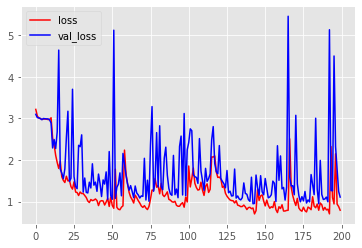

In [31]:
history = pd.DataFrame(hist.history)
#plt.figure(figsize=(12,12))

plt.plot(history["loss"], 'r',label='loss')
plt.plot(history["val_loss"], 'b', label='val_loss')
plt.legend()
plt.show()

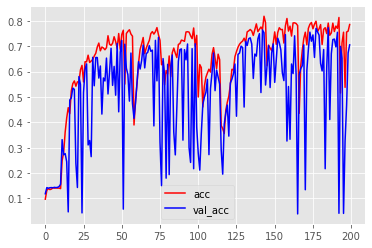

In [32]:
history = pd.DataFrame(hist.history)
#plt.figure(figsize=(12,12))

plt.plot(history["accuracy"], 'r',label='acc')
plt.plot(history["val_accuracy"], 'b', label='val_acc')
plt.legend()
plt.show()

In [33]:
#random sampling
test_label = 'cachorro'
predicted_label = 'gato'
while test_label != predicted_label:
    
    random_number = int(random.random()*len(x_input))
    test_string = x_input[random_number]
    test_label = categories[y[random_number].argmax()]

    padded_sequence_to_predict = preprocess_to_predict(string=test_string,
                                                    word_vectors=raw_embedding,
                                                    tokenizer=t
                                                    )
    prediction = model.predict(padded_sequence_to_predict)[0] #predict always returns a list
    predicted_label = categories[prediction.argmax()]
    
    if test_label == predicted_label:
        print(f'Test input: {test_string} \nLabel is: {test_label} Predicted: {predicted_label}')

Test input: vaso mônaco <unk> l p h ] <unk> <unk> 
Label is: Vasos Predicted: Vasos


In [34]:
test_string = """
celulares
"""


padded_sequence_to_predict = preprocess_to_predict(string=test_string,
                                                word_vectors=raw_embedding,
                                                tokenizer=t
                                                )
prediction = model.predict(padded_sequence_to_predict)[0] #predict always returns a list
predicted_label = categories[prediction.argmax()]


print(f'Predicted: {predicted_label}')

Predicted: Fogão
